In [277]:
# !conda install langdetect
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from functools import reduce
import re
import string
from langdetect import detect_langs
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt

In [204]:
master_df = pd.read_csv('articles_export.csv', index_col=0)

In [4]:
pd.reset_option('display.max_colwidth')

In [205]:
# master_df = master_df.drop_duplicates()
master_df.info()
master_df.drop(columns=['Unnamed: 0'], inplace=True)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10290 entries, 0 to 29
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               8452 non-null   float64
 1   title                    10290 non-null  object 
 2   url                      10290 non-null  object 
 3   time_published           10290 non-null  object 
 4   authors                  10290 non-null  object 
 5   summary                  10290 non-null  object 
 6   banner_image             9921 non-null   object 
 7   source                   10290 non-null  object 
 8   category_within_source   4560 non-null   object 
 9   source_domain            10290 non-null  object 
 10  topics                   10290 non-null  object 
 11  overall_sentiment_score  10290 non-null  float64
 12  overall_sentiment_label  10290 non-null  object 
 13  ticker_sentiment         10290 non-null  object 
 14  ticker                   10290

In [206]:
master_df['source'].value_counts()

source
Benzinga            4560
Zacks Commentary    3478
Motley Fool         2252
Name: count, dtype: int64

In [207]:
articles_missing = master_df[master_df['article'].isna()]
articles_missing.shape

(59, 15)

In [208]:
master_df.drop(columns=['summary', 'banner_image', 'category_within_source', 'topics', 'ticker_sentiment'], inplace=True)

In [209]:
master_df = master_df.dropna()
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10231 entries, 0 to 29
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    10231 non-null  object 
 1   url                      10231 non-null  object 
 2   time_published           10231 non-null  object 
 3   authors                  10231 non-null  object 
 4   source                   10231 non-null  object 
 5   source_domain            10231 non-null  object 
 6   overall_sentiment_score  10231 non-null  float64
 7   overall_sentiment_label  10231 non-null  object 
 8   ticker                   10231 non-null  object 
 9   article                  10231 non-null  object 
dtypes: float64(1), object(9)
memory usage: 879.2+ KB


In [211]:
master_df = master_df.drop_duplicates()

In [212]:
master_df.groupby('ticker').count()['article']


ticker
AAPL    647
ABNB    340
ADBE    347
ADP      71
AMD     544
ANET    386
AVGO    430
BABA    348
CRWD    353
CSCO    315
DELL    234
GOOG    326
IBM     135
INTU    168
META    455
MSFT    428
MU      193
NFLX    421
NVDA    540
ORCL    259
PLTR    249
PYPL    366
QCOM    374
SHOP    480
SPOT    297
TSLA    447
TSM     363
UBER    369
Name: article, dtype: int64

In [213]:
master_df['article'].nunique()

9019

<h2> Benzinga Clean Up

In [214]:
benzinga_df = master_df[master_df['source'] == 'Benzinga']

In [215]:
benzinga_df.shape

(4357, 10)

In [216]:
common_keywords = ['To read this article', 'Please click here to sign up', 'Photo by',
                   'This story was generated', 'Photo via', 'Check out more of Benzinga',
                   'Photo courtesy:', 'This article is from an unpaid external', '©', 'This article was generated by']

In [217]:
# pd.reset_option('display.max_colwidth')
# benzinga_df['cut1_article'] = benzinga_df['article'].apply(lambda x: x[-350:])
# pd.set_option('display.max_colwidth', None)
# benzinga_df['cut1_article'][:25]

In [218]:
def trim_by_keyword(article, keyword):
    return article.split(keyword)[0]

def trim_articles(articles, keywords):
    return [reduce(trim_by_keyword, keywords, article) for article in articles]



In [219]:
benzinga_df['cut2_articles'] = trim_articles(benzinga_df['article'], common_keywords)

/var/folders/k7/_jdxw9bx3_7cybsnkxz0pr200000gn/T/ipykernel_50579/1812483282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benzinga_df['cut2_articles'] = trim_articles(benzinga_df['article'], common_keywords)


In [220]:
benzinga_df.shape

(4357, 11)

In [221]:
benzinga_df['article']

0     Advanced Energy Industries AEIS reported non-G...
8     To gain an edge, this is what you need to know...
11    T-Mobile US, Inc TMUS reported its second-quar...
12    Tim Sweeney, the CEO of Epic Games, has public...
20    Leading cryptocurrencies edged lower Tuesday a...
                            ...                        
5     Someone with a lot of money to spend has taken...
7     Image sourced from Unsplash This post contains...
9     Image sourced from Unsplash This post contains...
18    This post contains sponsored advertising conte...
24    © 2024 Benzinga.com. Benzinga does not provide...
Name: article, Length: 4357, dtype: object

In [222]:
benzinga_df['cut2_articles']

0     Advanced Energy Industries AEIS reported non-G...
8     To gain an edge, this is what you need to know...
11    T-Mobile US, Inc TMUS reported its second-quar...
12    Tim Sweeney, the CEO of Epic Games, has public...
20    Leading cryptocurrencies edged lower Tuesday a...
                            ...                        
5     Someone with a lot of money to spend has taken...
7     Image sourced from Unsplash This post contains...
9     Image sourced from Unsplash This post contains...
18    This post contains sponsored advertising conte...
24                                                     
Name: cut2_articles, Length: 4357, dtype: object

In [223]:
benzinga_df['char_count'] = benzinga_df['cut2_articles'].apply(lambda x: len(x))

/var/folders/k7/_jdxw9bx3_7cybsnkxz0pr200000gn/T/ipykernel_50579/2557628087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benzinga_df['char_count'] = benzinga_df['cut2_articles'].apply(lambda x: len(x))


In [224]:
benzinga_df.shape

(4357, 12)

In [225]:
benzinga_df['char_count'].sort_values()[150:200]

5505      0
1798      0
6373      0
5224      0
5176      0
5219      0
5270      0
5177      0
1773      0
5173      0
1797      0
5274      0
5170      0
31        2
3         2
8182      2
2900      2
5930      2
4912      2
1509      2
49       15
1896     58
3583     58
5178     59
5275     62
971      63
4767     69
77       74
2188     76
3149     76
354      76
8066     76
3096     79
1416     82
4973     86
8026     88
3153     88
2183     89
5249     89
4279     90
6742     93
5256     95
6        99
2599    100
1899    100
931     101
8       104
1719    105
1842    106
60      114
Name: char_count, dtype: int64

In [226]:
# pd.set_option('display.max_colwidth', None)
# benzinga_df[benzinga_df['char_count'] == 668]['cut2_articles']

In [227]:
# benzinga_df[benzinga_df['char_count'] == 668]['article']

In [228]:
benzinga_df['char_count'].count()

4357

In [229]:
benzinga_df = benzinga_df[benzinga_df['char_count'] > 10]

In [230]:
benzinga_df.shape

(4187, 12)

In [231]:
benzinga_df['char_count'].sort_values()[0:50]

49       15
3583     58
1896     58
5178     59
5275     62
971      63
4767     69
77       74
2188     76
3149     76
354      76
8066     76
3096     79
1416     82
4973     86
8026     88
3153     88
5249     89
2183     89
4279     90
6742     93
5256     95
6        99
1899    100
2599    100
931     101
8       104
1719    105
1842    106
60      114
3845    116
74      116
2857    117
2834    123
3782    125
5       126
49      126
26      129
6024    132
3195    132
5000    134
5054    134
6156    135
25      136
26      136
2009    136
4642    137
6665    137
6201    137
1276    139
Name: char_count, dtype: int64

In [232]:
benzinga_df[(benzinga_df['char_count'] > 500) & (benzinga_df['char_count'] < 600)]['cut2_articles']

1101    NVIDIA NVDA has outperformed the market over t...
1473    On CNBC’s “The Final Call,” Carter Worth said,...
1857    Broadcom AVGO has outperformed the market over...
1879    Broadcom AVGO has outperformed the market over...
3754    Micron Technology MU has outperformed the mark...
3789    U.S. stocks were slightly higher, with the Dow...
4313    Broadcom AVGO has outperformed the market over...
4320    Broadcom AVGO has outperformed the market over...
4335    Broadcom AVGO has outperformed the market over...
4361    Broadcom AVGO has outperformed the market over...
4409    Meta Platforms META has outperformed the marke...
4458    Meta Platforms META has outperformed the marke...
4651    Oracle ORCL has outperformed the market over t...
4666    Oracle ORCL has outperformed the market over t...
4702    Oracle ORCL has outperformed the market over t...
4729    Oracle ORCL has outperformed the market over t...
4738    Advanced Micro Devices AMD has outperformed th...
4772    Advanc

In [233]:
benzinga_df[(benzinga_df['char_count'] > 500) & (benzinga_df['char_count'] < 600)]['article']

1101    NVIDIA NVDA has outperformed the market over t...
1473    On CNBC’s “The Final Call,” Carter Worth said,...
1857    Broadcom AVGO has outperformed the market over...
1879    Broadcom AVGO has outperformed the market over...
3754    Micron Technology MU has outperformed the mark...
3789    U.S. stocks were slightly higher, with the Dow...
4313    Broadcom AVGO has outperformed the market over...
4320    Broadcom AVGO has outperformed the market over...
4335    Broadcom AVGO has outperformed the market over...
4361    Broadcom AVGO has outperformed the market over...
4409    Meta Platforms META has outperformed the marke...
4458    Meta Platforms META has outperformed the marke...
4651    Oracle ORCL has outperformed the market over t...
4666    Oracle ORCL has outperformed the market over t...
4702    Oracle ORCL has outperformed the market over t...
4729    Oracle ORCL has outperformed the market over t...
4738    Advanced Micro Devices AMD has outperformed th...
4772    Advanc

In [234]:
benzinga_df = benzinga_df[benzinga_df['char_count'] > 400]

In [235]:
benzinga_df.drop(columns=['article', 'char_count'], inplace=True)
benzinga_df.rename(columns={'cut2_articles': 'article'}, inplace=True)

In [236]:
benzinga_df.shape

(4076, 10)

<h2> Zacks Commentary

In [237]:
zacks_df = master_df[master_df['source'] == 'Zacks Commentary']

In [238]:
zacks_df['article'].head(20)

1     Advanced Micro Devices (AMD Quick QuoteAMD  - ...
2     Skyworks Solutions (SWKS Quick QuoteSWKS  -  F...
3     Advanced Energy Industries (AEIS Quick QuoteAE...
4     Apple (AAPL Quick QuoteAAPL  -  Free Report)  ...
5     Garmin Ltd. (GRMN Quick QuoteGRMN  -  Free Rep...
6     PayPal Holdings, Inc. (PYPL Quick QuotePYPL  -...
7     All eyes are on technology giant Apple (AAPL Q...
10    Upstart Holdings (UPST Quick QuoteUPST  -  Fre...
14    The Schwab Fundamental U.S. Broad Market ETF (...
15    If you're interested in broad exposure to the ...
16    The WisdomTree U.S. LargeCap Dividend ETF (DLN...
17    Designed to provide broad exposure to the Tech...
19    Chicago, IL – July 31, 2024 – Today, Zacks Inv...
24    As the world’s most valuable company, markets ...
25    IPG Photonics (IPGP Quick QuoteIPGP  -  Free R...
27    Apple’s (AAPL Quick QuoteAAPL  -  Free Report)...
28    ONESPAN (OSPN Quick QuoteOSPN  -  Free Report)...
29    Mettler-Toledo International, Inc. (MTD Qu

<h2> Motley Fool

In [239]:
motley_df = master_df[master_df['source'] == 'Motley Fool']

In [240]:
motley_df['article'].head(20)

9      The biggest companies in tech aren't going all...
13     The Russell 2000 features approximately 2,000 ...
18     After years of struggle, SoundHound AI (SOUN -...
23     Nvidia (NVDA 1.72%) stock fell again in Tuesda...
82     Fool.com contributor Parkev Tatevosian preview...
101    In this podcast, Motley Fool analyst Jason Mos...
102    In this podcast, Motley Fool analyst Sanmeet D...
108    For most stocks, a trillion-dollar valuation w...
109    The S&P 500 is widely considered the best meas...
110    Widely followed Wall Street analyst Toni Sacco...
126    Following a volatile start to the decade, the ...
138    Microsoft (MSFT -1.02%) won the PC battle agai...
144    If you're young and already investing for reti...
145    Most investors focus on a company's growth pro...
146    Meta Platforms (META -1.21%) has been crushing...
148    Investors love to look at what Berkshire Hatha...
149    ExxonMobil (XOM -0.02%) is one of the world's ...
155    Anyone who follows Warre

In [241]:
print(benzinga_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4076 entries, 0 to 18
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    4076 non-null   object 
 1   url                      4076 non-null   object 
 2   time_published           4076 non-null   object 
 3   authors                  4076 non-null   object 
 4   source                   4076 non-null   object 
 5   source_domain            4076 non-null   object 
 6   overall_sentiment_score  4076 non-null   float64
 7   overall_sentiment_label  4076 non-null   object 
 8   ticker                   4076 non-null   object 
 9   article                  4076 non-null   object 
dtypes: float64(1), object(9)
memory usage: 350.3+ KB
None


In [242]:
print(zacks_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3292 entries, 1 to 27
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    3292 non-null   object 
 1   url                      3292 non-null   object 
 2   time_published           3292 non-null   object 
 3   authors                  3292 non-null   object 
 4   source                   3292 non-null   object 
 5   source_domain            3292 non-null   object 
 6   overall_sentiment_score  3292 non-null   float64
 7   overall_sentiment_label  3292 non-null   object 
 8   ticker                   3292 non-null   object 
 9   article                  3292 non-null   object 
dtypes: float64(1), object(9)
memory usage: 282.9+ KB
None


In [243]:
print(motley_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2236 entries, 9 to 29
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    2236 non-null   object 
 1   url                      2236 non-null   object 
 2   time_published           2236 non-null   object 
 3   authors                  2236 non-null   object 
 4   source                   2236 non-null   object 
 5   source_domain            2236 non-null   object 
 6   overall_sentiment_score  2236 non-null   float64
 7   overall_sentiment_label  2236 non-null   object 
 8   ticker                   2236 non-null   object 
 9   article                  2236 non-null   object 
dtypes: float64(1), object(9)
memory usage: 192.2+ KB
None


In [244]:
new_master_df = pd.concat([benzinga_df, zacks_df, motley_df])
new_master_df.reset_index(inplace=True, drop=True)
# new_master_df.drop(columns=['Unnamed: 0'], inplace=True)
new_master_df.head()

,title,url,time_published,authors,source,source_domain,overall_sentiment_score,overall_sentiment_label,ticker,article
0,"Advanced Energy Q2 Earnings Top Estimates, Rev...",https://www.benzinga.com/news/earnings/24/07/4...,20240731T201919,['Zacks'],Benzinga,www.benzinga.com,0.126429,Neutral,AAPL,Advanced Energy Industries AEIS reported non-G...
1,Oversold Condition And China Loophole Overpowe...,https://www.benzinga.com/markets/asia/24/07/40...,20240731T153854,['The Arora Report'],Benzinga,www.benzinga.com,0.204111,Somewhat-Bullish,AAPL,"To gain an edge, this is what you need to know..."
2,"T-Mobile's Q2 Earnings: Net Postpaid Adds, Rec...",https://www.benzinga.com/news/earnings/24/07/4...,20240731T125206,['Anusuya Lahiri'],Benzinga,www.benzinga.com,0.211757,Somewhat-Bullish,AAPL,"T-Mobile US, Inc TMUS reported its second-quar..."
3,Epic Games' Tim Sweeney Slams Apple's 'Find My...,https://www.benzinga.com/news/24/07/40066966/e...,20240731T123649,['Rounak Jain'],Benzinga,www.benzinga.com,-0.095462,Neutral,AAPL,"Tim Sweeney, the CEO of Epic Games, has public..."
4,"Bitcoin, Ethereum, Dogecoin Slide As Mt. Gox M...",https://www.benzinga.com/markets/cryptocurrenc...,20240731T030145,['Aniket Verma'],Benzinga,www.benzinga.com,0.002398,Neutral,AAPL,Leading cryptocurrencies edged lower Tuesday a...


In [271]:
new_master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9604 entries, 0 to 9603
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   title                      9604 non-null   object 
 1   url                        9604 non-null   object 
 2   time_published             9604 non-null   object 
 3   authors                    9604 non-null   object 
 4   source                     9604 non-null   object 
 5   source_domain              9604 non-null   object 
 6   overall_sentiment_score    9604 non-null   float64
 7   overall_sentiment_label    9604 non-null   object 
 8   ticker                     9604 non-null   object 
 9   article                    9604 non-null   object 
 10  overall_cleaned_sentiment  9604 non-null   float64
dtypes: float64(2), object(9)
memory usage: 825.5+ KB


In [94]:
#create column for articles in lower case
# new_master_df['to_lower'] = new_master_df['article'].apply(lambda x: x.lower())

In [95]:
#create column for articles in lower and with no numbers
# new_master_df['no_nums'] = new_master_df['to_lower'].apply(lambda x: re.sub(r'\d+', '', x))

In [96]:
# new_master_df['no_punc'] = new_master_df['no_nums'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [97]:
# new_master_df['final_trimmed'] = new_master_df['no_punc'].apply(lambda x: x.strip())

In [169]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matthewelmajian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewelmajian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [245]:
def preprocess_and_lemmatize(df, article_col):
    lemmatizer = WordNetLemmatizer()
    articles = df[article_col]
    lower_case = [x.lower() for x in articles]
    no_nums = [re.sub(r'\d+', '', x) for x in lower_case]
    no_punc = [x.translate(str.maketrans('', '', string.punctuation)) for x in no_nums]
    no_emojis = [re.sub(r'[^a-zA-Z\s]', '', x) for x in no_punc]
    words = [word_tokenize(x) for x in no_emojis]
    lemmatized_articles = [' '.join([lemmatizer.lemmatize(word) for word in article]) for article in words]
    return lemmatized_articles

In [246]:
# def preprocess_and_lemmatize(text):
#     text = re.sub(r'\W+', ' ', text)
#     new_text = re.sub(r'[^a-zA-Z\s]', '', text)
#     words = word_tokenize(new_text.lower())
#     lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
#     return ' '.join(lemmatized_words)

In [247]:
lemmatized_docs = preprocess_and_lemmatize(new_master_df, 'article')

In [248]:
len(lemmatized_docs)

9604

<h1> Vectorizing

In [174]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

<h2> CountVectorizer

In [249]:
c_vectorizer = CountVectorizer(stop_words='english', max_features = 2500)

In [250]:
c_X = c_vectorizer.fit_transform(lemmatized_docs)

In [251]:
c_feature_names = c_vectorizer.get_feature_names_out()

In [252]:
c_Xdense = c_X.toarray()

In [253]:
c_df = pd.DataFrame(c_Xdense, columns = c_feature_names)

In [254]:
sum_scores = np.sum(c_Xdense, axis=0)

In [255]:
count_df = pd.DataFrame({'word': c_feature_names, 'sum_score': sum_scores})

In [283]:
count_df = count_df.sort_values(by='sum_score', ascending=False)
count_df.head()

,word,sum_score
425,company,43102
685,earnings,42532
2481,year,39950
2142,stock,37897
1007,ha,36109


Text(0.5, 0, 'Count')

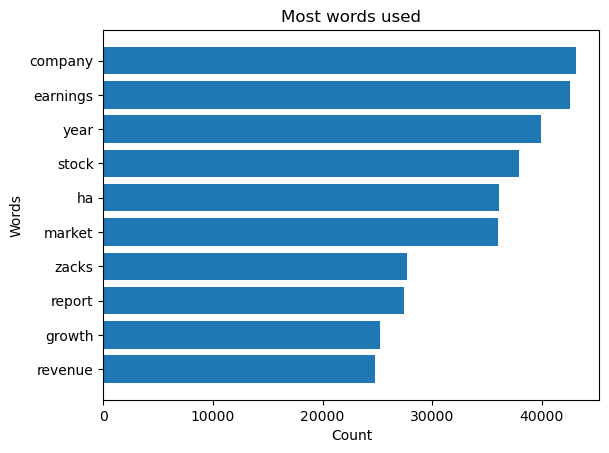

In [286]:
plt.barh(count_df['word'][0:10], count_df['sum_score'][0:10])
plt.gca().invert_yaxis()
plt.title('Most words used')
plt.ylabel('Words')
plt.xlabel('Count')

In [118]:
key_words = ['buy', 'sale', 'strong', 'beat', 'higher', 'increase', 'positive', 'gain', 'lower', 'trend', 
            'big', 'bullish', 'increased', 'potential', 'valuation', 'cost', 'decline', 'good', 'bearish',
            'sell', 'major', 'loss', 'profit', 'low', 'growing', 'indicating', 'despite', 'leading', 'momentum',
            'exposure', 'rising', 'grow', 'rise', 'solution', 'bad', 'worse', 'negative', 'poor']

In [257]:
c_df.to_csv('count_vectorizer_matrix.csv')

In [185]:
count_df.set_index('word').T

word,aapl,ability,able,abnb,abr,absolutely,accelerate,accelerated,accelerating,acceleration,...,young,youre,youtube,youve,yoy,ytd,zacks,zackscom,zero,zoom
sum_score,1914,1458,2049,606,339,352,682,549,395,277,...,236,2877,1004,762,477,303,28940,494,587,510


<h2>TFIDF Vectorizer

In [258]:
t_vectorizer = TfidfVectorizer(stop_words='english', max_features=2500)

In [259]:
X = t_vectorizer.fit_transform(lemmatized_docs)

In [260]:
feature_names = t_vectorizer.get_feature_names_out()

In [261]:
X_dense = X.todense()

In [262]:
df = pd.DataFrame(X_dense, columns=feature_names)

In [263]:
df.head()

,aapl,ability,able,abnb,abr,absolutely,accelerate,accelerated,accelerating,acceleration,...,young,youre,youtube,youve,yoy,ytd,zacks,zackscom,zero,zoom
0,0.032577,0.0,0.000000,0.0,0.0,0.0,0.0,0.0455,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.21039,0.0,0.0,0.0
1,0.031085,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,0.041105,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
3,0.048799,0.0,0.050857,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,0.042934,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [192]:
row = X[0]
non_zero_indices = row.nonzero()[1]
tfidf_scores = row[0, non_zero_indices]
words_with_scores = {feature_names[idx]: tfidf_scores[0, i] for i, idx in enumerate(non_zero_indices)}
pd.DataFrame([words_with_scores]).T.sort_values(by=0, ascending=False).head(30)

,0
revenue,0.260513
million,0.255483
year,0.249439
declined,0.226630
energy,0.217174
zacks,0.209786
sequentially,0.209709
nongaap,0.204153
advanced,0.202925
consensus,0.140503


In [193]:
mean_tfidf_scores = np.mean(X.toarray(), axis=0)

In [194]:
tfidf_df = pd.DataFrame({'word': feature_names, 'mean_score': mean_tfidf_scores})

In [195]:
tfidf_df = tfidf_df.sort_values('mean_score', ascending = False)

In [275]:
tfidf_df[0:10]

,word,mean_score
685,earnings,0.071928
2496,zacks,0.065156
2138,stock,0.054455
427,company,0.052494
2481,year,0.049795
1856,report,0.045976
1008,ha,0.045018
1346,market,0.044887
761,estimate,0.043932
1756,quarter,0.040944


Text(0.5, 0, 'TFIDF Mean Score')

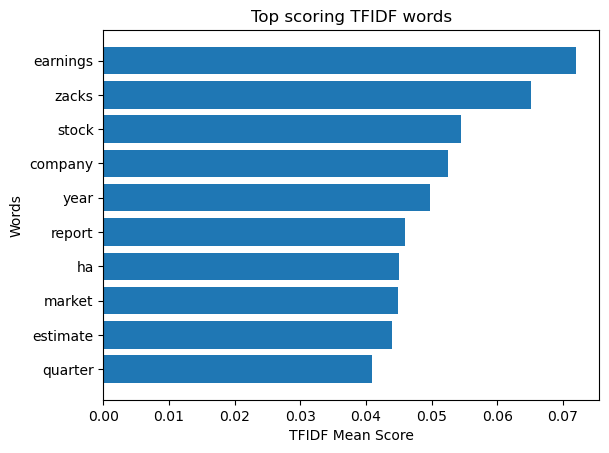

In [281]:
plt.barh(tfidf_df['word'][0:10], tfidf_df['mean_score'][0:10])
plt.gca().invert_yaxis()
plt.title('Top scoring TFIDF words')
plt.ylabel('Words')
plt.xlabel('TFIDF Mean Score')

In [264]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [265]:
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']


In [266]:
new_master_df['overall_cleaned_sentiment'] = [get_sentiment(doc) for doc in tqdm(lemmatized_docs)]

100%|█████████████████████████████| 9604/9604 [03:33<00:00, 45.02it/s]


In [79]:
new_master_df['uncleaned_sentiment'] = [get_sentiment(doc) for doc in tqdm(new_master_df['article'])]

100%|███████████████████████████████| 8156/8156 [02:23<00:00, 56.78it/s]


In [267]:
new_master_df.head()

,title,url,time_published,authors,source,source_domain,overall_sentiment_score,overall_sentiment_label,ticker,article,overall_cleaned_sentiment
0,"Advanced Energy Q2 Earnings Top Estimates, Rev...",https://www.benzinga.com/news/earnings/24/07/4...,20240731T201919,['Zacks'],Benzinga,www.benzinga.com,0.126429,Neutral,AAPL,Advanced Energy Industries AEIS reported non-G...,0.9981
1,Oversold Condition And China Loophole Overpowe...,https://www.benzinga.com/markets/asia/24/07/40...,20240731T153854,['The Arora Report'],Benzinga,www.benzinga.com,0.204111,Somewhat-Bullish,AAPL,"To gain an edge, this is what you need to know...",0.9464
2,"T-Mobile's Q2 Earnings: Net Postpaid Adds, Rec...",https://www.benzinga.com/news/earnings/24/07/4...,20240731T125206,['Anusuya Lahiri'],Benzinga,www.benzinga.com,0.211757,Somewhat-Bullish,AAPL,"T-Mobile US, Inc TMUS reported its second-quar...",0.9875
3,Epic Games' Tim Sweeney Slams Apple's 'Find My...,https://www.benzinga.com/news/24/07/40066966/e...,20240731T123649,['Rounak Jain'],Benzinga,www.benzinga.com,-0.095462,Neutral,AAPL,"Tim Sweeney, the CEO of Epic Games, has public...",-0.9020
4,"Bitcoin, Ethereum, Dogecoin Slide As Mt. Gox M...",https://www.benzinga.com/markets/cryptocurrenc...,20240731T030145,['Aniket Verma'],Benzinga,www.benzinga.com,0.002398,Neutral,AAPL,Leading cryptocurrencies edged lower Tuesday a...,0.5256


In [268]:
new_master_df.to_csv('articles_with_sentiment.csv')



In [269]:
df.to_csv('tfidf_sparse_matrix.csv')

In [273]:
len(new_master_df['ticker'].unique())

28

In [297]:
pd.set_option('display.max_colwidth', None)
new_master_df[new_master_df['overall_cleaned_sentiment'] < 0]['ticker'].value_counts()

ticker
AAPL    35
TSLA    34
AMD     20
BABA    19
CRWD    18
NVDA    16
AVGO    15
MSFT    15
CSCO    13
NFLX    12
META    12
UBER    11
PYPL    11
MU      10
ABNB    10
TSM     10
SPOT     9
SHOP     9
GOOG     9
QCOM     9
INTU     7
ADBE     7
PLTR     4
ORCL     3
IBM      2
ADP      2
DELL     1
Name: count, dtype: int64